# Analisis de Ciudades

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from wordcloud import WordCloud, STOPWORDS
from difflib import SequenceMatcher

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,23533.0,NaN,NaN,2015-08-23 00:00:00,0.0,0.0,0.0,0.0,0.0,2273000.0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,24514.0,19.310205,-99.227655,2013-06-28 00:00:00,0.0,0.0,0.0,1.0,1.0,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,48551.0,NaN,NaN,2015-10-17 00:00:00,0.0,0.0,0.0,0.0,0.0,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,53666.0,19.301890,-99.688015,2012-03-09 00:00:00,0.0,0.0,0.0,1.0,1.0,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,47835.0,NaN,NaN,2016-06-07 00:00:00,0.0,0.0,0.0,0.0,0.0,1150000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240

# Asignacion de zonas a las publicaciones

In [4]:
def definir_zona(lat):
    if lat >= 25:
        return 'Norte'
    if lat < 20:
        return 'Sur'
    if 20 < lat < 25:
        return 'Centro'
    return np.nan
    
    

zonas = df.set_index('ciudad')['lat'].transform(definir_zona)
aux = df.loc[:,['ciudad']]
aux['zona'] = df['lat'].transform(definir_zona)
aux['cant'] = 1

df2 = aux.groupby(['ciudad','zona']).agg({'cant':'count'}).reset_index()
df2 = df2[df2.groupby('ciudad')['cant'].transform('max') == df2['cant']].loc[:,['ciudad','zona']].set_index('ciudad')

df = df2.merge(df, on = 'ciudad', how = 'inner')


In [5]:
def min_threshold(df, threshold):
    '''Funcion para filtrar por una minima cantidad de datos'''
    return df["ciudad"].count() > threshold

#Filtro la informacion a ciudades de mas de 400 propiedades
df = df.groupby(['ciudad','provincia']).filter(min_threshold, threshold = 2000)
df['provincia'].value_counts()

Distrito Federal         50247
Edo. de México           29236
Jalisco                  17620
Querétaro                14664
Puebla                    8441
San luis Potosí           7925
Yucatán                   7162
Nuevo León                6946
Quintana Roo              3779
Morelos                   3775
Chihuahua                 3757
Baja California Norte     2863
Sonora                    2590
Guerrero                  2454
Durango                   2048
Name: provincia, dtype: int64

In [6]:
df["fecha_publicacion"] = pd.to_datetime(df["fecha"])
df["año_publicacion"] = df["fecha_publicacion"].dt.year
df["mes_publicacion"] = df["fecha_publicacion"].dt.month

In [7]:
fechas = df.groupby(['año_publicacion', 'mes_publicacion']).agg({'mes_publicacion': 'size'})
fechas = fechas.rename(columns = {'mes_publicacion':'publicaciones'})
fechas = fechas.reset_index().pivot(index="año_publicacion", columns = "mes_publicacion", values = "publicaciones")
fechas = fechas.T
for año in fechas.columns:
    fechas[año]/=fechas[año].sum()
fechas

año_publicacion,2012,2013,2014,2015,2016
mes_publicacion,,,,,
1,0.069251,0.058954,0.052870,0.080303,0.062907
2,0.055620,0.048759,0.058006,0.073701,0.050525
3,0.049318,0.058848,0.066734,0.076867,0.055342
4,0.061443,0.062652,0.069248,0.074053,0.071514
5,0.075416,0.066931,0.076826,0.073485,0.057567
6,0.066032,0.066719,0.077688,0.075271,0.072235
7,0.085417,0.091337,0.076647,0.078274,0.061925
8,0.149188,0.081511,0.088248,0.090287,0.068844
9,0.115556,0.102377,0.100460,0.090206,0.063919


## ¿Existe crecimiento anual? ¿Existe alguna epoca del año de mayor flujo de propiedades?

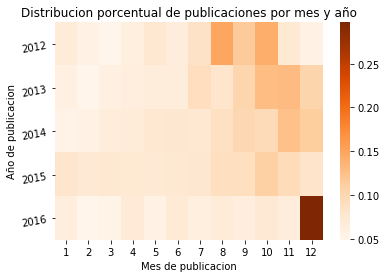

In [8]:
ax = sns.heatmap(fechas.T, cmap="Oranges")
ax.set_yticklabels(ax.get_yticklabels(), rotation=10)
plt.title("Distribucion porcentual de publicaciones por mes y año")
plt.xlabel("Mes de publicacion")
plt.ylabel("Año de publicacion")
ax.set_ylim(5.0, 0)
plt.savefig("figs/heatmap_fechas.png")
plt.show()

# Relacion habitaciones / banos. ¿Que combinacion es comun?

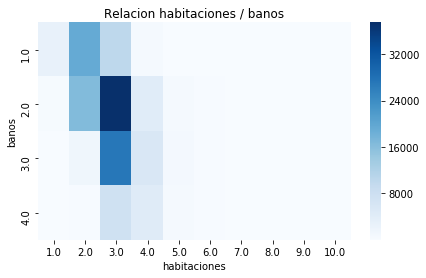

In [9]:
habitaciones_banos = df.groupby(['habitaciones', 'banos']).agg({'id':'count'})
habitaciones_banos.rename(columns = {'id':'cantidad'}, inplace=True)
habitaciones_banos = habitaciones_banos.\
                                        reset_index()\
                                        .pivot(index="habitaciones", columns = "banos", values = "cantidad")

plt.figure(figsize = (7,4))
ax = sns.heatmap(habitaciones_banos.T, cmap="Blues")
ax.set_ylim(4.0, 0)
plt.title('Relacion habitaciones / banos')
plt.savefig('./figs/heatmap_habitaciones_banos.png')
plt.show()

## Ciudades - Antiguedad

In [10]:
antiguedades = df.groupby('ciudad').agg({'antiguedad': 'mean', 'ciudad': 'size'})
antiguedades.rename(columns = {'antiguedad' : 'antiguedad_promedio','ciudad':'cantidad_de_propiedades'}, inplace = True)
antiguedades.sort_values('antiguedad_promedio', ascending = False)
# Antiguedades promedio, ciudades +- viejas

,antiguedad_promedio,cantidad_de_propiedades
ciudad,,
Gustavo A. Madero,16.052927,3141
Coyoacán,15.118539,5293
Iztapalapa,14.504088,3093
Cuauhtémoc,13.982537,6539
Tlalnepantla de Baz,13.616530,3588
Naucalpan de Juárez,13.355570,6554
Ecatepec de Morelos,12.348546,2159
Guadalajara,12.016341,4006
Tlalpan,11.651100,5721


In [11]:
grandes_ciudades = df.groupby('ciudad').filter(min_threshold, threshold = 7000)
antiguedades_ciudades = grandes_ciudades.groupby(['ciudad', 'antiguedad']).agg({'ciudad':'size'})
antiguedades_ciudades = antiguedades_ciudades.rename(columns = {'ciudad':'cantidades'}).reset_index()
antiguedades_ciudades = antiguedades_ciudades.reset_index().pivot('ciudad', 'antiguedad', 'cantidades')

for antiguedad in antiguedades_ciudades.columns:
    antiguedades_ciudades[antiguedad]/=antiguedades_ciudades[antiguedad].sum()

antiguedades_ciudades = antiguedades_ciudades.T.iloc[:20].T
antiguedades_ciudades

antiguedad,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
ciudad,,,,,,,,,,,,,,,,,,,,
Benito Juárez,0.139317,0.188008,0.225248,0.209741,0.255358,0.300532,0.278481,0.373702,0.280453,0.234899,0.295008,0.173077,0.210526,0.200000,0.160714,0.216000,0.283333,0.260870,0.074074,0.076923
Mérida,0.192490,0.201558,0.116337,0.084053,0.088181,0.070754,0.120253,0.072664,0.076487,0.100671,0.077536,0.230769,0.092105,0.050000,0.071429,0.122667,0.066667,0.043478,0.024691,0.076923
Querétaro,0.311829,0.319106,0.311056,0.386489,0.314146,0.222050,0.343882,0.304498,0.297450,0.308725,0.184280,0.243590,0.355263,0.466667,0.375000,0.240000,0.316667,0.217391,0.345679,0.384615
San Luis Potosí,0.160421,0.141599,0.106436,0.073056,0.075934,0.080027,0.128692,0.093426,0.164306,0.147651,0.071429,0.185897,0.118421,0.066667,0.142857,0.160000,0.133333,0.108696,0.172840,0.192308
Zapopan,0.195944,0.149729,0.240924,0.246661,0.266381,0.326636,0.128692,0.155709,0.181303,0.208054,0.371747,0.166667,0.223684,0.216667,0.250000,0.261333,0.200000,0.369565,0.382716,0.269231


## ¿Son parejas las antiguedades para ciudades en distintas condiciones?

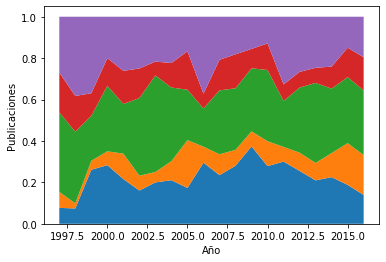

In [12]:
ax = plt.stackplot(list(map(lambda x:2016-x, list(antiguedades_ciudades.columns))),antiguedades_ciudades)
plt.xlabel('Año')
plt.ylabel('Publicaciones')
plt.show()

# Horrible este plot, meu deus

## ¿Existen patrones para cantidad de habitaciones por ciudad?

In [13]:
def obtener_promedio_por_ciudad_de(df, parametro):
    nuevo_df = df.groupby(['ciudad',parametro]).agg({parametro:'size', 'precio':'mean'})
    nuevo_df.rename(columns = {parametro:'cantidad'}, inplace = True)
    cantidades = df.groupby('ciudad').agg({parametro:'sum'})[parametro]
    nuevo_df = nuevo_df.reset_index().set_index('ciudad')
    nuevo_df['totales'] = cantidades
    return nuevo_df

def agrupar_y_aplicar(df, agrupaciones, targets, funciones):
    d = {}
    for target in targets:
        for func in funciones:
            if len(funciones) == 1:
                d[target] = func
            else:
                d[target] = d.get(target, []) + [func]
    return df.groupby(agrupaciones).agg(d)


In [14]:
def filtrar_cantidad(df, cantidad):
    df['cantidad'] = 1
    df2 = df.groupby('provincia').agg({'cantidad':'size'})
    return df.loc[df['provincia'].isin(df2[df2['cantidad'] > cantidad].index)]

def generar_barplot_ciudades(df, nombre):
    plt.figure(figsize=(15, 5))
    serie = setup_barplot_ciudades(df,nombre)
    for provincia in serie['provincia'].unique():
        ax = sns.barplot(x=nombre, y = 'ciudad', data = serie.loc[serie['provincia'] == provincia], palette="Oranges_d")
        plt.title(f'Porcentaje de {nombre} para la provincia {provincia} segun ciudad')
        plt.xlabel('Porcentaje de banos')
        #plt.savefig(f'./figs/{provincia}_porcentaje_{nombre}_por_ciudad.jpg')
        
def setup_barplot_ciudades(df, caracteristica):
    provincias_mas_grandes = filtrar_cantidad(df,7000)
    serie = agrupar_y_aplicar(provincias_mas_grandes, ['provincia','ciudad'], [caracteristica], ['sum']).reset_index()
    serie_provincias = serie.groupby('provincia').agg({caracteristica:'sum'})
    serie.set_index('provincia',inplace=True)
    serie[caracteristica] /= serie_provincias[caracteristica]
    serie[caracteristica] *= 100
    serie = serie.reset_index()
    return serie
        
#generar_barplot_ciudades(df, 'banos')
#generar_barplot_ciudades(df, 'habitaciones')
#generar_barplot_ciudades(df, 'garages')

In [15]:
habitaciones = agrupar_y_aplicar(df, ['ciudad'], ['habitaciones'], ['mean'])#['habitaciones']
habitaciones#.sort_values(ascending = False).head(10)

,habitaciones
ciudad,
Acapulco de Juárez,2.820273
Alvaro Obregón,2.760814
Atizapán de Zaragoza,3.047750
Benito Juárez,2.535092
Cancún,2.887238
Chihuahua,3.063410
Corregidora,2.973422
Coyoacán,3.034008
Cuajimalpa de Morelos,2.645631


In [16]:
garages = agrupar_y_aplicar(df, ['ciudad'], ['garages'], ['mean'])['garages']
garages.sort_values(ascending = False).head(10)

ciudad
Huixquilucan             2.180480
Naucalpan de Juárez      1.965706
Cuajimalpa de Morelos    1.965517
Cuernavaca               1.859864
Mérida                   1.854254
Atizapán de Zaragoza     1.850216
San Andrés Cholula       1.821909
Querétaro                1.792965
Corregidora              1.755367
Alvaro Obregón           1.733743
Name: garages, dtype: float64

## La cercania a un centro comercial tiene un impacto positivo en el precio de una propiedad para cualquier ciudad

In [17]:
precios_promedio_por_ciudad = df.groupby('ciudad').agg({'precio':'mean'})
precios_promedio_por_ciudad_con_comercio = df[df['centroscomercialescercanos'] == 1].groupby('ciudad').agg({'precio':'mean'})

## ¿Es el nivel de oferta una variable que afecte al valor del metro cuadrado cubierto?

Text(0, 0.5, 'Cantidad de publicaciones del mes')

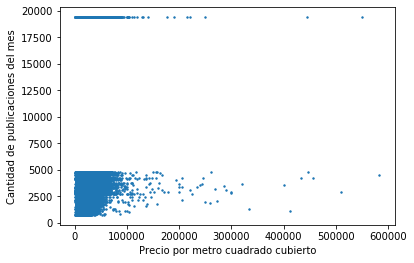

In [18]:
plt.scatter(df['precio']/df['metroscubiertos'], df.groupby(['mes_publicacion', 'año_publicacion'])['mes_publicacion'].transform('count'), s=2)
plt.xlabel('Precio por metro cuadrado cubierto')
plt.ylabel('Cantidad de publicaciones del mes')

In [19]:
sin_diciembre = df.loc[lambda x:(x['año_publicacion'] != 2016) | (x['mes_publicacion'] != 12), ['mes_publicacion','año_publicacion','zona','precio','metroscubiertos']]

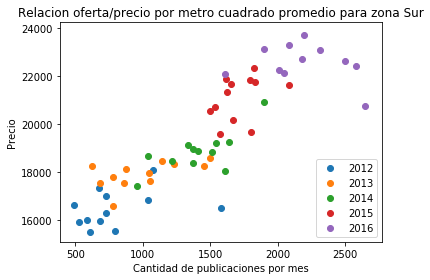

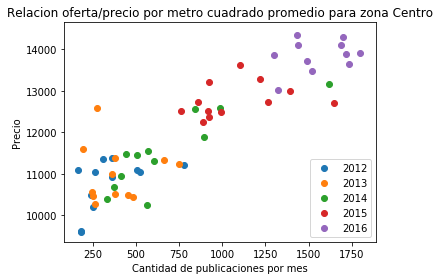

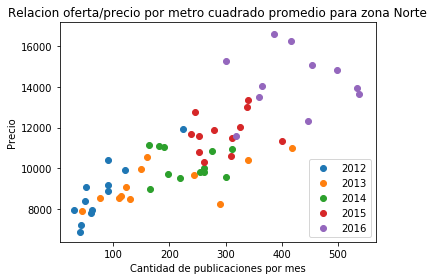

In [20]:
def generar_scatter(df,zona):
    #plt.figure(figsize = (16,6))
    for año in range(2012,2017):
        nuevo_df = pd.DataFrame()
        info = df.loc[lambda x:(x['año_publicacion'] == año)]\
                                            .groupby(['mes_publicacion','año_publicacion'])
        info = info.agg({'precio':'sum', 'metroscubiertos':'sum', 'mes_publicacion':'count'})
        plt.scatter(info['mes_publicacion'],info['precio']/info['metroscubiertos'], label = año)
        plt.ylabel('Precio')
        plt.xlabel('Cantidad de publicaciones por mes')
        plt.title(f'Relacion oferta/precio por metro cuadrado promedio para zona {zona}')
        plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.savefig(f'./figs/scatter_oferta_precio_zona_{zona}.jpg')
    


#generar_scatter(sin_diciembre)
for zona in sin_diciembre['zona'].unique():
    generar_scatter(sin_diciembre.loc[lambda x:x['zona'] == zona,], zona)
    plt.show()

    

¿A mayor cantidad de publicaciones mensuales, mayor dispersion en los precios y mayor precio promedio?

Ideas a implementar: 
- Dividir a las ciudades en 4 zonas (N-O-S-E) y utilizar colores para los mismos y ver si hay relaciones espaciales
- Agregar una curva para los valores promedios de cada barra de puntos para ver el desvio
